# Evaluation of a single model

Haerang Lee

This time, we pick one model and look deeper into it. 

In [1]:
from google.cloud import storage
import argparse
import gzip
import os
import sys
import time
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from utils import gcs_utils as gcs
from utils import model_and_evaluate_cluster as ev
import urllib.parse
import urllib.request

import io 

import importlib
import hdbscan
import networkx as nx 

import matplotlib.pyplot as plt


We pick our best model. 

In [8]:
prefix='mvp_input/2021_1029_0054/'

In [10]:
# Import model outputs
all_protein_combos_per_cluster = gcs.download_parquet(prefix+'all_protein_combos_per_cluster.parquet')
model = gcs.download_pkl(prefix + "model.pkl")
model_overview =  gcs.download_pkl(prefix + "model_overview.pkl")
cluster_data = gcs.download_parquet(prefix+'alphafold_proteins_in_model.parquet')

In [15]:
model_overview

{'Model': "HDBSCAN(algorithm='generic', metric='cosine', min_samples=1)",
 'Length of embedding': 1024,
 'Number of clusters categories (incl. noise)': 758,
 'Number of clusters (excl. noise)': 757,
 'Noise': 11579,
 'Largest non-noise cluster': 416,
 'Noise as % of total': 0.5647190792040577,
 'Noise and largest cluster as % of total': 0.5850078033554429}

Run functional similarity evaluation

In [80]:
funsim_result = ev.funsim_evaluator(all_protein_combos_per_cluster)
funsim_result.funsim()
cluster_funsim, protein_pair_funsim = funsim_result.cluster_funsim, funsim_result.protein_pair_funsim

2021-Nov-07 18:42:28 No GO annotations provided. Downloading from google cloud.


/var/folders/zz/58vwrfdn6p5bgkhdv0xng5780000gn/T/ipykernel_33077/139992989.py:1: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  funsim_result = ev.funsim_evaluator(all_protein_combos_per_cluster)


2021-Nov-07 18:42:32 Total number of proteins in GO annotations: 18240
2021-Nov-07 18:42:32 IC_t created
2021-Nov-07 18:42:32 Dictionary of proteins and their GO terms lookup created
2021-Nov-07 18:42:35 Funsim calculated.
2021-Nov-07 18:42:35 Funsim summary by cluster done.
2021-Nov-07 18:42:35 Get NP Arr of GO terms for each protein
2021-Nov-07 18:42:35 Turn GO terms into dict
2021-Nov-07 18:42:35 Map GO desc...
2021-Nov-07 18:42:35 Mapping GO desc done.
2021-Nov-07 18:42:35 Common GO term sumary per cluster processed.
2021-Nov-07 18:42:35 Merged cluster-level funsim score with GO summary.


In [81]:
cluster_summ = cluster_data.pivot_table(index='cluster_label',
                         values='protein',
                         aggfunc=len
                        ).sort_values(by='protein', ascending=False)

In [86]:
cluster_summ.head()

,protein
cluster_label,
-1,11579
579,416
578,195
755,129
421,99


In [87]:
cluster_summ.index

Int64Index([ -1, 579, 578, 755, 421, 667, 455, 735, 349, 564,
            ...
            414, 410, 404, 403, 397, 395, 625, 391, 383, 448],
           dtype='int64', name='cluster_label', length=758)

Sort results by funsim. But only look at those clusters where the available number of pairs exceeds 10.

In [68]:
cluster_funsim[
    cluster_funsim.num_pairs_with_funsim >= 10
].shape

(682, 7)

Most clusters have at least 10 pairs available.

Here's a histogram of % of pairs with funsim. Most are concentrated near 100%, which means we have pretty good data availability.

(array([  1.,   1.,   0.,   0.,   2.,   2.,   2.,   1.,   4.,   6.,   0.,
          2.,   3.,   4.,   1.,   6.,   2.,   3.,   3.,  11.,  14.,   6.,
          8.,   6.,   8.,  10.,   3.,   7.,   3., 563.]),
 array([0.06493506, 0.0961039 , 0.12727273, 0.15844156, 0.18961039,
        0.22077922, 0.25194805, 0.28311688, 0.31428571, 0.34545455,
        0.37662338, 0.40779221, 0.43896104, 0.47012987, 0.5012987 ,
        0.53246753, 0.56363636, 0.59480519, 0.62597403, 0.65714286,
        0.68831169, 0.71948052, 0.75064935, 0.78181818, 0.81298701,
        0.84415584, 0.87532468, 0.90649351, 0.93766234, 0.96883117,
        1.        ]),
 <BarContainer object of 30 artists>)

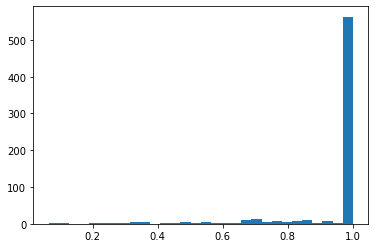

In [75]:
plt.hist(cluster_funsim[
    (cluster_funsim.num_pairs_with_funsim >= 10)
]["perc_pairs_w_funsim"], bins=30)

Now, let's look at funsim values. It ranges from 0 to 1. The median is 0.29. 

We will need to see what the good ones and bad ones look like.

In [79]:
cluster_funsim.funsim.describe()

count    728.000000
mean       0.340266
std        0.247720
min        0.000000
25%        0.149892
50%        0.287396
75%        0.463663
max        1.000000
Name: funsim, dtype: float64

(array([10., 42., 43., 45., 56., 51., 30., 38., 43., 44., 38., 24., 27.,
        25., 23., 14., 12., 10., 19., 12., 13.,  6.,  9.,  6.,  5.,  4.,
         5.,  4.,  5., 19.]),
 array([0.00570253, 0.03884578, 0.07198903, 0.10513228, 0.13827553,
        0.17141878, 0.20456203, 0.23770528, 0.27084852, 0.30399177,
        0.33713502, 0.37027827, 0.40342152, 0.43656477, 0.46970802,
        0.50285127, 0.53599452, 0.56913776, 0.60228101, 0.63542426,
        0.66856751, 0.70171076, 0.73485401, 0.76799726, 0.80114051,
        0.83428376, 0.867427  , 0.90057025, 0.9337135 , 0.96685675,
        1.        ]),
 <BarContainer object of 30 artists>)

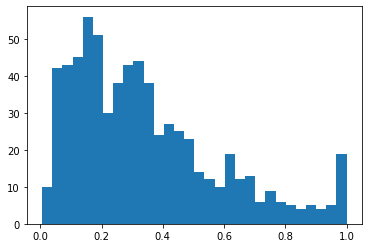

In [78]:
plt.hist(cluster_funsim[
    (cluster_funsim.num_pairs_with_funsim >= 10)
]["funsim"], bins=30)

The funsim score might correlate with the cluster size, but given that most (75th percentile) are under 13, it may not be worth looking into.

In [91]:
cluster_summ[cluster_summ.index!=-1]["protein"].describe()

count    757.000000
mean      11.789960
std       19.092008
min        5.000000
25%        6.000000
50%        8.000000
75%       13.000000
max      416.000000
Name: protein, dtype: float64

# The most functionally similar clusters.

In [69]:
cluster_funsim[
    cluster_funsim.num_pairs_with_funsim > 10
].sort_values(["funsim", "num_pairs_with_funsim"], ascending=False).head(20)

,num_pairs,num_pairs_with_funsim,funsim,perc_pairs_w_funsim,cluster,go,go_summary
cluster,,,,,,,
102,435,378,1.000000,0.868966,102,"{'GO:0003823': 28, 'GO:0034987': 28}","{'GO:0003823': {'Num. Protein': 28, 'Name': 'a..."
103,105,105,1.000000,1.000000,103,"{'GO:0003823': 15, 'GO:0034987': 15}","{'GO:0003823': {'Num. Protein': 15, 'Name': 'a..."
104,55,55,1.000000,1.000000,104,"{'GO:0003823': 11, 'GO:0034987': 11}","{'GO:0003823': {'Num. Protein': 11, 'Name': 'a..."
372,45,45,1.000000,1.000000,372,"{'GO:0003713': 10, 'GO:0008134': 10, 'GO:00469...","{'GO:0003713': {'Num. Protein': 10, 'Name': 't..."
576,28,28,1.000000,1.000000,576,"{'GO:0004930': 8, 'GO:0004984': 8}","{'GO:0004930': {'Num. Protein': 8, 'Name': 'G ..."
100,66,21,1.000000,0.318182,100,{'GO:0003823': 7},"{'GO:0003823': {'Num. Protein': 7, 'Name': 'an..."
731,15,15,1.000000,1.000000,731,"{'GO:0005509': 6, 'GO:0048306': 6}","{'GO:0005509': {'Num. Protein': 6, 'Name': 'ca..."
177,21,21,0.994013,1.000000,177,"{'GO:0005515': 1, 'GO:0008420': 7, 'GO:0106306...","{'GO:0008420': {'Num. Protein': 7, 'Name': 'RN..."
705,15,15,0.990172,1.000000,705,"{'GO:0000977': 6, 'GO:0000981': 6, 'GO:0001227...","{'GO:0000977': {'Num. Protein': 6, 'Name': 'RN..."


In [95]:
clusterno = 102
print("Cluster number: #" + str(clusterno))
print("Total number of proteins:", cluster_summ.loc[clusterno][0])
funsim_result.get_go_summary_df(clusterno=clusterno)


Cluster number: #102
Total number of proteins: 30


,Num. Protein,Name,Description
GO:0003823,28,antigen binding,"Binding to an antigen, any substance which is ..."
GO:0034987,28,immunoglobulin receptor binding,Binding to one or more specific sites on an im...


This cluster has GO terms for 28 out of 30 proteins. And they are exactly the same: `GO:0003823 (antigen binding)` and `GO:0034987 (immunoglobulin receptor binding)`. The other two has a very high likelihood of also being some form of an immunoglobulin. Let's see what they are.

In [107]:
funsim_result.unique_proteins[funsim_result.unique_proteins.cluster==clusterno]

,query_protein,cluster,go
1,A0A075B6Q5,102,"[GO:0034987, GO:0003823]"
30,A0A075B7D8,102,"[GO:0034987, GO:0003823]"
60,A0A075B7E8,102,"[GO:0034987, GO:0003823]"
90,A0A075B7F0,102,"[GO:0034987, GO:0003823]"
120,A0A0A0MS15,102,"[GO:0034987, GO:0003823]"
150,A0A0B4J1V1,102,"[GO:0034987, GO:0003823]"
180,A0A0B4J1V6,102,"[GO:0034987, GO:0003823]"
210,A0A0B4J1X5,102,"[GO:0034987, GO:0003823]"
240,A0A0B4J1X8,102,"[GO:0034987, GO:0003823]"
270,A0A0B4J1Y9,102,"[GO:0034987, GO:0003823]"


Protein IDs `P0DTE1` and `S4R460` are the only ones that are missing the GO terms. A couple of hypotheses on why they may be missing. 

1. The GO terms were dropped in the process of GO term QC process before Gene Ontology Consortium shared the data. 
2. These are new proteins we haven't had much research around.

PDB has [`P0DTE1`](https://www.uniprot.org/uniprot/P0DTE1) as "*Probable* non-functional immunoglobulin heavy variable." Perhaps the label was dropped because of 'probable" or "non-functional". Not sure.

PDB has [`S4R460`](https://www.uniprot.org/uniprot/S4R460) as "Immunoglobulin heavy variable 3/OR16-9 (non-functional)". Why is this non-functional? And is that why, although it has GOMF mapped to it, it was removed in the GO annotation we downloaded?



Next cluster!

In [110]:
clusterno = 100
print("Cluster number: #" + str(clusterno))
print("Total number of proteins:", cluster_summ.loc[clusterno][0])
funsim_result.get_go_summary_df(clusterno=clusterno)


Cluster number: #100
Total number of proteins: 12


,Num. Protein,Name,Description
GO:0003823,7,antigen binding,"Binding to an antigen, any substance which is ..."


7 of 12 proteins are antigen binding. 

In [111]:
funsim_result.unique_proteins[funsim_result.unique_proteins.cluster==clusterno]

,query_protein,cluster,go
1,A0A075B6I0,100,[]
12,A0A075B6I6,100,[]
24,A0A075B6I9,100,[]
36,A0A075B6J9,100,[]
48,A0A0B4J1U3,100,[]
60,P01699,100,[GO:0003823]
72,P01700,100,[GO:0003823]
84,P01701,100,[GO:0003823]
96,P01705,100,[GO:0003823]
108,P01706,100,[GO:0003823]


Protein `A0A075B6I0` has a function description on UniProt: 
> V region of the variable domain of immunoglobulin light chains that participates in the antigen recognition 

I looked at a few other ones starting with an `A` and the annotation score is often "Protein inferred from homology" or "Experimental evidence at protein level"

> The value 'Protein inferred by homology' indicates that the existence of a protein is probable because clear orthologs exist in closely related species.

> The value 'Experimental evidence at protein level' indicates that there is clear experimental evidence for the existence of the protein. The criteria include partial or complete Edman sequencing, clear identification by mass spectrometry, X-ray or NMR structure, good quality protein-protein interaction or detection of the protein by antibodies.

# Largest Clusters
The two largest clusters are `579` and `578`. In the visualization, they're also the closest to each other.

In [112]:
cluster_summ[0:10]

,protein
cluster_label,
-1,11579
579,416
578,195
755,129
421,99
667,89
455,69
735,67
349,65


In [113]:
clusterno = 579
print("Cluster number: #" + str(clusterno))
print("Total number of proteins:", cluster_summ.loc[clusterno][0])
funsim_result.get_go_summary_df(clusterno=clusterno)


Cluster number: #579
Total number of proteins: 416


,Num. Protein,Name,Description
GO:0004984,415,olfactory receptor activity,Combining with an odorant and transmitting the...
GO:0004930,403,G protein-coupled receptor activity,Combining with an extracellular signal and tra...
GO:0005549,115,odorant binding,"Binding to an odorant, any substance capable o..."
GO:0005515,19,protein binding,Binding to a protein.
GO:0004993,12,G protein-coupled serotonin receptor activity,Combining with the biogenic amine serotonin an...
GO:0030594,12,neurotransmitter receptor activity,Combining with a neurotransmitter and transmit...
GO:0003674,7,molecular_function,A molecular process that can be carried out by...
GO:0038023,3,signaling receptor activity,Receiving a signal and transmitting it in the ...
GO:0003707,1,steroid hormone receptor activity,Combining with a steroid hormone and transmitt...
GO:0004888,1,transmembrane signaling receptor activity,Combining with an extracellular or intracellul...


Looks like `579` is mostly olfactory receptors. What is that one protein in this cluster that doesn't have the olfactory receptor GO?

In [119]:
funsim_result.unique_proteins[(funsim_result.unique_proteins.cluster==clusterno) &
                              (funsim_result.unique_proteins.go.apply(lambda x: len(x))==0)
                             ]

,query_protein,cluster,go
416,A0A0G2JMP0,579,[]


It is `Olfactory receptor 4M2`. The annotation score is 1 of 5, Protein predicted. The status is unreviewed.

> The value 'Protein predicted' is used for entries without evidence at protein, transcript, or homology levels.

In [23]:
clusterno = 578
funsim_result.get_go_summary_df(clusterno=clusterno)


,Num. Protein,Name,Description
GO:0004930,132,G protein-coupled receptor activity,Combining with an extracellular signal and tra...
GO:0005515,118,protein binding,Binding to a protein.
GO:0016493,21,C-C chemokine receptor activity,Combining with a C-C chemokine and transmittin...
GO:0019957,21,C-C chemokine binding,Binding to a C-C chemokine; C-C chemokines do ...
GO:0042277,21,peptide binding,"Binding to a peptide, an organic compound comp..."
...,...,...,...
GO:0099582,1,neurotransmitter receptor activity involved in...,Any neurotransmitter receptor activity that is...
GO:0099626,1,voltage-gated calcium channel activity involve...,Regulation of presynaptic cytosolic calcium io...
GO:1990081,1,trimethylamine receptor activity,Combining with the biogenic amine trimethylami...
GO:1990239,1,steroid hormone binding,Binding to a steroid hormone.


`578` isn't necessarily olfactory receptors. Two thirds of these proteins are G protein-coupled receptor activity, but this group appear to be a lot more diverse than the cluster `579`.

Are there any other clusters with a lot of olfactory receptors?

In [29]:
val = 'GO:0004984'   # olfactory receptor activity
cluster_funsim[cluster_funsim.go.apply(lambda x:
                        True if val in x else False)]

,num_pairs,num_pairs_with_funsim,funsim,perc_pairs_w_funsim,cluster,go,go_summary
cluster,,,,,,,
565,15,15,0.132912,1.000000,565,"{'GO:0004875': 1, 'GO:0004930': 4, 'GO:0004961...","{'GO:0004930': {'Num. Protein': 4, 'Name': 'G ..."
576,28,28,1.000000,1.000000,576,"{'GO:0004930': 8, 'GO:0004984': 8}","{'GO:0004930': {'Num. Protein': 8, 'Name': 'G ..."
579,86320,85905,0.774198,0.995192,579,"{'GO:0003674': 7, 'GO:0003707': 1, 'GO:0004888...","{'GO:0004984': {'Num. Protein': 415, 'Name': '..."


In [36]:
cluster_summ.loc[565]

protein    6
Name: 565, dtype: int64

In [38]:
clusterno = 565
funsim_result.get_go_summary_df(clusterno=clusterno)


,Num. Protein,Name,Description
GO:0004930,4,G protein-coupled receptor activity,Combining with an extracellular signal and tra...
GO:0005515,2,protein binding,Binding to a protein.
GO:0004875,1,complement receptor activity,Combining with any component or product of the...
GO:0004961,1,thromboxane A2 receptor activity,Combining with thromboxane A2 (TXA(2)) and tra...
GO:0004982,1,N-formyl peptide receptor activity,Combining with an N-formyl peptide to initiate...
GO:0004984,1,olfactory receptor activity,Combining with an odorant and transmitting the...
GO:0005085,1,guanyl-nucleotide exchange factor activity,Stimulates the exchange of GDP to GTP on a sig...
GO:0005549,1,odorant binding,"Binding to an odorant, any substance capable o..."
GO:0030594,1,neurotransmitter receptor activity,Combining with a neurotransmitter and transmit...
GO:0038023,1,signaling receptor activity,Receiving a signal and transmitting it in the ...


In [39]:
cluster_summ.loc[576]

protein    8
Name: 576, dtype: int64

In [40]:
clusterno = 576
funsim_result.get_go_summary_df(clusterno=clusterno)


,Num. Protein,Name,Description
GO:0004930,8,G protein-coupled receptor activity,Combining with an extracellular signal and tra...
GO:0004984,8,olfactory receptor activity,Combining with an odorant and transmitting the...


It appears as though cluster `576` should have been in the same cluster as `579`. 8 of 8 proteins in `576` are olfactory receptors. 

Let's look these up.

In [42]:
clusterno = 576
cluster_data[cluster_data.cluster_label==clusterno]

,protein,cluster_label,x,y,z
877,A6NGY5,576,3.557391,3.080409,2.283168
13588,Q8NGF3,576,3.540617,3.082165,2.316787
13605,Q8NGH6,576,3.534824,3.089223,2.300925
13623,Q8NGJ5,576,3.551631,3.061340,2.340415
13752,Q8NH55,576,3.567841,3.057984,2.296201
13758,Q8NH63,576,3.567914,3.060516,2.280823
13759,Q8NH64,576,3.550771,3.135579,2.191715
13766,Q8NH76,576,3.540814,3.077823,2.337334


In [43]:
clusterno = 579
cluster_data[cluster_data.cluster_label==clusterno]

,protein,cluster_label,x,y,z
105,A0A096LPK9,579,3.029725,3.234825,3.775876
233,A0A0G2JMP0,579,3.043796,3.224734,3.744421
241,A0A0G2JNH3,579,3.028982,3.232947,3.785290
296,A0A0X1KG70,579,3.039039,3.220428,3.780077
297,A0A126GWB0,579,3.010431,3.208345,3.977160
...,...,...,...,...,...
20091,Q9Y3N9,579,3.002795,3.164186,4.127723
20138,Q9Y4A9,579,3.017837,3.218189,3.911835
20216,Q9Y585,579,3.004193,3.178328,4.069979
20295,Q9Y5P0,579,3.074250,3.317855,3.287262


# Less similar clusters

In [121]:
cluster_funsim[
    cluster_funsim.num_pairs_with_funsim > 10
].sort_values(["funsim", "num_pairs_with_funsim"], ascending=True).head(20)

,num_pairs,num_pairs_with_funsim,funsim,perc_pairs_w_funsim,cluster,go,go_summary
cluster,,,,,,,
398,28,15,0.021626,0.535714,398,"{'GO:0003674': 1, 'GO:0003779': 1, 'GO:0004385...","{'GO:0005515': {'Num. Protein': 5, 'Name': 'pr..."
748,21,15,0.023691,0.714286,748,"{'GO:0000049': 1, 'GO:0000287': 1, 'GO:0000978...","{'GO:0005515': {'Num. Protein': 6, 'Name': 'pr..."
743,325,210,0.031514,0.646154,743,"{'GO:0000166': 1, 'GO:0000976': 1, 'GO:0003674...","{'GO:0005515': {'Num. Protein': 14, 'Name': 'p..."
135,28,21,0.031545,0.750000,135,"{'GO:0000250': 1, 'GO:0004364': 1, 'GO:0004660...","{'GO:0005515': {'Num. Protein': 7, 'Name': 'pr..."
715,21,15,0.032130,0.714286,715,"{'GO:0005102': 1, 'GO:0005515': 5, 'GO:0019894...","{'GO:0005515': {'Num. Protein': 5, 'Name': 'pr..."
5,1378,1035,0.035866,0.751089,5,"{'GO:0000064': 2, 'GO:0000095': 1, 'GO:0000295...","{'GO:0005515': {'Num. Protein': 21, 'Name': 'p..."
589,21,21,0.036475,1.000000,589,"{'GO:0000404': 1, 'GO:0000405': 1, 'GO:0000979...","{'GO:0005515': {'Num. Protein': 6, 'Name': 'pr..."
622,36,36,0.039824,1.000000,622,"{'GO:0000976': 1, 'GO:0000978': 2, 'GO:0000981...","{'GO:0005515': {'Num. Protein': 7, 'Name': 'pr..."
49,28,15,0.042648,0.535714,49,"{'GO:0001618': 1, 'GO:0001968': 1, 'GO:0005080...","{'GO:0005515': {'Num. Protein': 6, 'Name': 'pr..."


Cluster 398 has a 0.02 funsim score. 5 of 8 are protein binding (`GO:0005515`) but the type of activity or molecule/protein it binds to looks different.

In [122]:
clusterno = 398
print("Cluster number: #" + str(clusterno))
print("Total number of proteins:", cluster_summ.loc[clusterno][0])
funsim_result.get_go_summary_df(clusterno=clusterno)


Cluster number: #398
Total number of proteins: 8


,Num. Protein,Name,Description
GO:0005515,5,protein binding,Binding to a protein.
GO:0003674,1,molecular_function,A molecular process that can be carried out by...
GO:0003779,1,actin binding,Binding to monomeric or multimeric forms of ac...
GO:0004385,1,guanylate kinase activity,Catalysis of the reaction: ATP + GMP = ADP + GDP.
GO:0005524,1,ATP binding,"Binding to ATP, adenosine 5'-triphosphate, a u..."
GO:0015631,1,tubulin binding,Binding to monomeric or multimeric forms of tu...
GO:0019888,1,protein phosphatase regulator activity,Binds to and modulates the activity of a prote...
GO:0030234,1,enzyme regulator activity,Binds to and modulates the activity of an enzyme.
GO:0043014,1,alpha-tubulin binding,Binding to the microtubule constituent protein...
GO:0045504,1,dynein heavy chain binding,Binding to a heavy chain of the dynein complex.


In [123]:
funsim_result.unique_proteins[funsim_result.unique_proteins.cluster==clusterno]

,query_protein,cluster,go
1,Q15435,398,"[GO:0005515, GO:0030234, GO:0019888]"
8,Q4LDG9,398,"[GO:0005515, GO:0045504, GO:0043014]"
16,Q53EV4,398,"[GO:0005515, GO:0003674]"
24,Q6ZRR7,398,[]
32,Q7Z4L9,398,"[GO:0003779, GO:0015631, GO:0070840]"
40,Q8IUZ0,398,[]
48,Q96M69,398,"[GO:0005515, GO:0004385, GO:0005524]"
56,Q9H069,398,[GO:0005515]


In [129]:
funsim_result.goa[funsim_result.goa['GO ID'].isin(funsim_result.goa_goid_mf)]#.to_parquet('functional_sim/goa_mf.parquet')

,DB,DB Object ID,DB Object Symbol,Qualifier,GO ID,Reference,Evidence Code,With or From,Aspect,Name,Synonym,Type,Taxon,Date,Assigned By,Annotation Extension,Gene Product Form ID
0,UniProtKB,A0A024RBG1,NUDT4B,enables,GO:0003723,GO_REF:0000043,IEA,UniProtKB-KW:KW-0694,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20210612,UniProt,NaN,NaN
1,UniProtKB,A0A024RBG1,NUDT4B,enables,GO:0046872,GO_REF:0000043,IEA,UniProtKB-KW:KW-0479,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20210612,UniProt,NaN,NaN
2,UniProtKB,A0A024RBG1,NUDT4B,enables,GO:0052840,GO_REF:0000003,IEA,EC:3.6.1.52,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20210612,UniProt,NaN,NaN
3,UniProtKB,A0A024RBG1,NUDT4B,enables,GO:0052842,GO_REF:0000003,IEA,EC:3.6.1.52,F,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,protein,taxon:9606,20210612,UniProt,NaN,NaN
240,UniProtKB,A0A075B734,LOC100509620,enables,GO:0015267,GO_REF:0000002,IEA,InterPro:IPR000425,F,Putative aquaporin-7-like protein 3,LOC100509620,protein,taxon:9606,20210612,InterPro,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609727,UniProtKB,Q99814,EPAS1,enables,GO:0000977,PMID:21873635,IBA,PANTHER:PTN001889196|UniProtKB:Q16665|MGI:MGI:...,F,Endothelial PAS domain-containing protein 1,EPAS1|BHLHE73|HIF2A|MOP2|PASD2,protein,taxon:9606,20210531,GO_Central,NaN,NaN
609733,UniProtKB,Q9NYV6,RRN3,enables,GO:0001181,PMID:21873635,IBA,PANTHER:PTN000300504|SGD:S000001608|PomBase:SP...,F,RNA polymerase I-specific transcription initia...,RRN3|TIFIA,protein,taxon:9606,20200808,GO_Central,NaN,NaN
609734,UniProtKB,Q9H1H9,KIF13A,enables,GO:0016887,PMID:21873635,IBA,PANTHER:PTN000648413|TAIR:locus:2157533|UniPro...,F,Kinesin-like protein KIF13A,KIF13A|RBKIN,protein,taxon:9606,20210905,GO_Central,NaN,NaN
609736,UniProtKB,P20813,CYP2B6,enables,GO:0016712,PMID:21873635,IBA,PANTHER:PTN000670347|UniProtKB:P24903,F,Cytochrome P450 2B6,CYP2B6,protein,taxon:9606,20210531,GO_Central,NaN,NaN


Find how many proteins had structures already  in UniProt outside of AlphaFold2 predictions

In [156]:
importlib.reload(ev)

<module 'utils.model_and_evaluate_cluster' from '/Users/haeranglee/Documents/pss/utils/model_and_evaluate_cluster.py'>

In [158]:
uniprot_stats  = ev.gen_cluster_uniprot_stats(cluster_data)

In [159]:
uniprot_stats

,cluster_label,num_proteins,num_proteins_has_3d,perc_proteins_has_3d
0,-1,11579,4096,0.353744
1,0,10,7,0.700000
2,1,24,0,0.000000
3,2,6,1,0.166667
4,3,5,0,0.000000
...,...,...,...,...
753,752,8,5,0.625000
754,753,24,3,0.125000
755,754,10,5,0.500000
756,755,129,43,0.333333


In [161]:
uniprot_stats.iloc[579]

cluster_label           578.000000
num_proteins            195.000000
num_proteins_has_3d      72.000000
perc_proteins_has_3d      0.369231
Name: 579, dtype: float64

In [162]:
uniprot_stats.iloc[580]

cluster_label           579.000000
num_proteins            416.000000
num_proteins_has_3d       1.000000
perc_proteins_has_3d      0.002404
Name: 580, dtype: float64